![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Computer Vision Concepts

You may recall *Practicum AI*"s heroine Amelia, the AI-savvy nutritionist. At the end of our *[Deep Learning Foundations course](https://practicumai.org/courses/deep_learning/)*, Amelia was helping with a computer vision project. Her colleague, an entomologist named Kevin, had a dataset of images of bees and wasps and wanted to classify them.

![Image of bees and wasps from the dataset cover image](https://github.com/PracticumAI/deep_learning/blob/main/images/bees_wasps_dataset-cover.png?raw=true)


## AI Pathway review for Bees vs Wasps

If you have taken our [Getting Started with AI course](https://practicumai.org/courses/getting_started/), you may remember this figure of the AI Application Development Pathway. Let"s take a quick review of how we applied this pathway in the case of the Bees vs Wasps example.

![AI Application Development Pathway image showing the 7 steps in developing an AI application](https://practicumai.org/getting_started/images/application_dev_pathway.png)

1. **Choose a problem to solve:** In this example, we need to classify images as bees, wasps, other insects, or a non-insect. 
2. **Gather data:** The data for the example come from [Kaggle](https://www.kaggle.com/), a great repository of datasets, code, and models.
3. **Clean and prepare the data:** In the *Deep Learning Foundations* course, we assumed that this was done for us. One issue that we ran into was that of class imbalance. There are many more images in some classes than others, leading to a poor performing model.
4. **Choose a model:** In the *Deep Learning Foundations* course, we presented the model with little detail. Now that we know more about Convolutional Neural Networks and some other tools at our disposal, we will explore the model in more detail.
   * As part of the iterative process among this and the next steps, one thing we noticed is that most of our models were overfitting — performing better on the training data than they did on the testing data. Essentially, the models memorized the training data but did not generalize well to new data that had not been seen. 
      * In this notebook, we will explore **dropout** as one mechanism to mitigate overfitting.
5. **Train the model:** In training the model we may have had a few issues. With so many hyperparameters to tune, it"s easy to lose track of what combinations have been tried and how changes impacted model performance. 
   * In this notebook, we introduce you to [TensorBoard](https://www.tensorflow.org/tensorboard), one popular tool in a class of tools known as **experiment tracking** or **MLOps (Machine learning operations) tools**. These tools help track changes to hyperparameters, the training process, and the data. They allow comparison among runs and can even automate multiple runs for you. Learning to use MLOps tools will help you as you continue to learn more about AI workflows.
6. **Evaluate the model:** We will continue to assess how the model performs on the test set and adjust the model and hyperparameters to attempt to produce a better model. However, as noted above in step 3, one issue is the class imbalance.    
   * This is a common issue with real data, and in notebook [02.1_data_imbalance.ipynb](02.1_data_imbalance.ipynb), we will explore some methods to handle this.
7. **Deploy the model:** We won"t get to this stage in this exercise, but hopefully, we will end up with a model that could be deployed and achieve relatively good accuracy at solving the problem.


## A refresher

If you need a refresher, or haven"t taken the *Deep Learning Foundations* course, the final notebook is part of this repository: [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb). No need to worry though, we will cover what we did before and the new changes as we work through this notebook. Some of the code has been moved into the [helpers_01.py](helpers_01.py) file and is imported below to keep things cleaner.

## 1. Import the libraries we will use

In [1]:
import tensorflow as tf  # Import the TensorFlow library, which provides tools for deep learning.
import pandas as pd  # Import the pandas library, used for data manipulation and analysis.
import datetime
import random

# Used for data management
import requests
import os
import time
import tarfile

import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualization.


# Import Keras libraries
from tensorflow.keras.models import (
    Sequential,
)  # Import the Sequential model: a linear stack of layers from Keras module in TensorFlow.
from tensorflow.keras.layers import (
    Dense,
)  # Import the Dense layer: a fully connected neural network layer from Keras module in TensorFlow.
from tensorflow.keras.layers import (
    Flatten,
)  # Import the Flatten layer: used to convert input data into a 1D array from Keras module in TensorFlow.
from tensorflow.keras.losses import (
    SparseCategoricalCrossentropy,
)  # Import the SparseCategoricalCrossentropy loss function from Keras module in TensorFlow.
from tensorflow.keras import layers
from tensorflow.keras import losses
from sklearn.metrics import confusion_matrix
import numpy as np

# Import helper functions--most of these were in the cells of the DLF_03_bees_vs_wasps.ipynb notebook.
# We moved them out of the notebook to enhance readability.
import helpers_01

In [2]:
print(tf.__version__)
tf.config.list_physical_devices("GPU")

2.7.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2. Jupyter magic commands

In Jupyter, the `%` is used as a "magic" command. These extend Python in various ways. In this case, Tensorboad functionality is added using `%load_ext tensorboard`

Again, [Tensorboard](https://www.tensorflow.org/tensorboard) is the tool we"ll use for experiment tracking in many of these notebooks. 

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## 3. Getting the data

Check the "Getting the data" section of [DLF_03_bees_vs_wasps.ipynb](DLF_03_bees_vs_wasps.ipynb#2.-Getting-the-data) for details about the dataset and the code used to get the data if needed. Or you can look at the [helpers_01.py file](helpers_01.py). 

If you need to download the data, it is [hosted for download from Dropbox here as a `tar.gz` file](https://www.dropbox.com/s/x70hm8mxqhe7fa6/bee_vs_wasp.tar.gz?dl=0). If you need to manually extract the data, you can add a cell and run: `helpers_01.extract_file("bee_vs_wasp.tar.gz", "data")`


In [4]:
# Check for the data.
# This will look for the data files required for this notebook in some common locations.
# If it can"t find the data, it will ask if you know where it is. If you do, answer yes and
# provide the path to the data (up to and including the `bee_vs_wasp` folder name). If not,
# it will ask if you want to download it. If you answer yes, it will download the data and
# extract it into your data folder.

data_path = helpers_01.manage_data()

Found data at data/bee_vs_wasp.


## 4. Examine some images

Many of the steps in this notebook are written as functions, making it easier to run these steps repeatedly as you work on optimizing the various hyperparameters.

The `helpers_01.load_display_data()` function takes: 
* A path to the data: set from above.
* The batch size: set as 32 below, but a good hyperparameter to tune.
* Target shape for images: set as 80x80 color images below, another possible hyperparameter.
* Whether or not to show sample images.

The function returns training and testing datasets. To help highlight the class imbalance issue, the function has been updated to report the numbers of images and percent of the total in each class.


******************************************************************
Load data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Stratify when sampling? False
  - Returning class counts for later use? False
******************************************************************

For the full dataset:
Number of wasp images: 4943, or 43.3%
Number of other_insect images: 2439, or 21.4%
Number of bee images: 3184, or 27.9%
Number of other_noinsect images: 856, or 7.5%
Found 9136 validated image filenames belonging to 4 classes.
Found 2285 validated image filenames belonging to 4 classes.
['bee', 'other_insect', 'other_noinsect', 'wasp']


/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


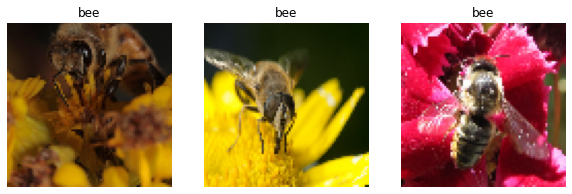

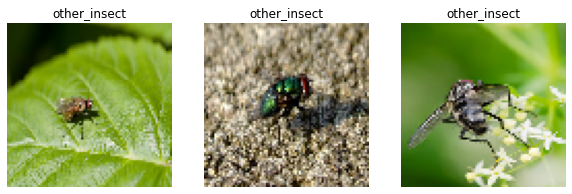

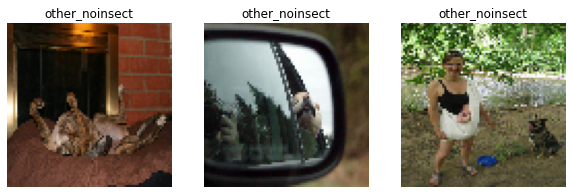

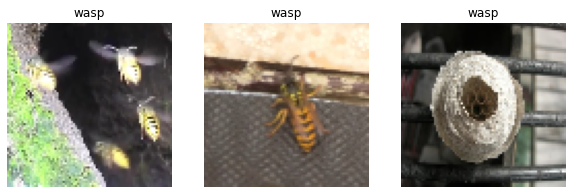


For the training dataset:
Number of bee images: 2573, or 28.2%
Number of other_insect images: 1933, or 21.2%
Number of other_noinsect images: 684, or 7.5%
Number of wasp images: 3947, or 43.2%


In [9]:
# The data path should be set from the cell above.
# If that failed and you want to set it manually, use the line below.
# data_path= "data/bee_vs_wasp"

data_train, data_val = helpers_01.load_display_data(
    data_path, batch_size=32, shape=(80, 80, 3), show_pictures=True
)

## 5. Set hyperparameters

In [10]:
# data_path = "data/bee_vs_wasp/" # Path to the data.
# This is defined above, you only need to change this if you change datasets

show_pictures = False  # We'll turn this off, but change to True if you want them...

# Hyperparameters
shape = (80, 80, 3)  # Dimensions to use for the images...the raw data are 80x80
#  color images, but you could down-sample them
#  or convert them to black and white if you wanted
batch_size = 32  # What batch size to use
classes = (
    4  # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
)
# Only change this if you change the dataset
activation = "relu"  # The activation function is an important hyperparameter
# Other activation functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=False)  # Loss function
# Other loss functions to try: losses.CategoricalHinge()
#                              losses.KLDivergence()

optimizer = "Adagrad"  # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate = (
    0.001  # Try increasing or decreasing the learning rate by an order of magnitude
)

epochs = 10  # Try running more epochs

## 6. Make our model

This function creates the model we will use.

One hyperparameter to explore is the activation function, which is set when making the model. We start with a ReLU as the default, but you can try others. For simplicity, we will use the same activation function for all but the last layer of the model, but you could change them individually.

The last layer will almost always use a Softmax, which makes all the output values between 0 and 1 and sum to 1, transforming them into "probabilities" of the input belonging to each possible class.

In [11]:
def make_model(activation="relu", shape=(80, 80, 3), num_classes=4):
    """Sets up a model.
    Takes in an activation function, shape for the input images, and number of classes.
    Returns the model."""
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")

    # Define the model
    model = tf.keras.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation=activation),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    return model


model = make_model()
model.summary()

***********************************************************************
Make model:
  - Using the activation function: relu.
  - Model will have 4 classes.
***********************************************************************
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                        

## 7. Compile and train the model

This step compiles the model, getting it ready for training. The primary hyperparameters here are:
* the **loss function** (how we determine how close the predicted output is to the known output values),
* the **optimization function** (how we determine which parameters should be updated and how),
* the **learning rate** (how much each parameter should be adjusted), and
* how many **epochs** should be run (remember, an epoch is a full pass through all the training data). 

### Add a TensorBoard callback

In Tensorflow, callbacks can be used during model training to control a number of things, like changing the learning rate each epoch, stopping training if model accuracy hasn't improved a set amount over a set number of epochs, etc. In this case, we will use a callback to log training data to a folder for TensorBoard to analyze.

We'll set the log path, adding the hyperparameter values we want to keep track of as part of the path name.

In [21]:
data_train

In [14]:
# Set dropout variable to "No_dropout" since we haven't added dropout to the model yet
dropout = "No_dropout"
time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = f"logs/fit_{activation}_{dropout}_{learning_rate}_{epochs}_{time}"
tensorboard_callback = '[log_dir=log_dir, histogram_freq=1]'


model, history = helpers_01.compile_train_model(
    data_train, data_val, model, callbacks=tensorboard_callback
)

******************************************************************
Compile and Train the model:
  - Using the loss function: <keras.losses.SparseCategoricalCrossentropy object at 0x149b220270a0>.
  - Using the optimizer: Adam.
  - Using learning rate of: 0.0001.
  - Running for 10 epochs.
   -Using class weights: {0: 1, 1: 1, 2: 1, 3: 1})
  - Using these callbacks: [log_dir=log_dir, histogram_freq=1]
******************************************************************
Epoch 1/10


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,4] and labels shape [128]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/backend.py:5113)
]] [Op:__inference_train_function_2654]

Errors may have originated from an input operation.
Input Source operations connected to node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] sparse_categorical_crossentropy/Reshape_1 (defined at /apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/backend.py:5109)	
In[1] sparse_categorical_crossentropy/Reshape (defined at /apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/__main__.py", line 5, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 724, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
>>>     handle._run()
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 512, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 501, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 408, in dispatch_shell
>>>     await result
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 731, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 424, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/scratch/local/45991456/ipykernel_2088079/665701596.py", line 9, in <cell line: 9>
>>>     model, history = helpers_01.compile_train_model(
>>> 
>>>   File "/blue/ufhpc/magitz/PracticumAI/computer_vision/helpers_01.py", line 383, in compile_train_model
>>>     history = model.fit(
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/training.py", line 809, in train_step
>>>     loss = self.compiled_loss(
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
>>>     loss_value = loss_obj(y_t, y_p, sample_weight=sw)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

## 8. Evaluate the model

Now that we have trained our model, let's evaluate how it performs.


In [ ]:
helpers_01.evaluate_model(X_train, X_test, model, history)

## 9. View training metrics in TensorBoard

Now that we've run one training cycle, we can open TensorBoard and have a look at the visualizations it provides to evaluate training performance.

The detailed instructions for different platforms are in the course content. In general, we use the `tensorboard --logdir ./logs` command to start TensorBoard and then connect in a Web browser. Here's a screenshot of what that might look like:

![Screenshot of the TensorBoard web page](images/tensorboard_screenshot.png)



## 10. Explore hyperparameters!

OK, we've trained the model once using some decent first guesses. Now, we can see if we can do better by exploring different hyperparameters.

While there are methods to explore different hyperparameters systematically and track the results more efficiently, we will rely on some ad-hoc exploration and keep everything in the notebook.

The following function pulls all the steps from above into a single function.

In [16]:
def the_whole_shebang(
    path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True
):
    X_train, X_test = helpers_01.load_display_data(
        data_path, batch_size, shape, show_pictures
    )
    model = make_model(activation=activation, shape=shape, num_classes=classes)

    # Set dropout variable to "No_dropout" since we haven't added dropout to the model yet
    dropout = "No_dropout"
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = f"logs/fit_{activation}_{dropout}_{learning_rate}_{epochs}_{time}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, histogram_freq=1
    )

    model, history = helpers_01.compile_train_model(
        X_train,
        X_test,
        model,
        loss=loss,
        optimizer=optimizer,
        learning_rate=learning_rate,
        epochs=epochs,
        callbacks=tensorboard_callback,
    )
    helpers_01.evaluate_model(X_train, X_test, model, history, classes)

### Copy the next cell and change hyperparameters

You can copy the next cell multiple times and adjust the hyperparameters to compare results.

In [ ]:
# data_path = "data/bee_vs_wasp/" # Path to the data.
# This is defined above, you only need to change this if you change datasets

show_pictures = True  # Show sample images from the dataset? Keep on at first, but may become distracting.
# Set to False to turn off

# Hyperparameters
shape = (80, 80, 3)  # Dimensions to use for the images...the raw data are 80x80
#  color images, but you could down-sample them
#  or convert them to black and white if you wanted
batch_size = 64  # What batch size to use
classes = (
    4  # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
)
# Only change this if you change the dataset
activation = "relu"  # The activation function is an important hyperparameter
# Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=False)  # Loss function
# Other loss functions to try: losses.CategoricalHinge()
#                              losses.KLDivergence()

optimizer = "Adagrad"  # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate = (
    0.001  # Try increasing or decreasing the learning rate by an order of magnitude
)

epochs = 10  # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(
    data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures
)

## 11. Summary so far

Some of the points we can take away so far include:

* Most of the time, our model struggles to do better than about 70% accuracy on the validation data. Accuracy on the training data is closer to 90%. This suggests that our model is overfit to the training data.
* Additionally, while 70% doesn't sound too bad, the confusion matrix makes it clear that the model favors predicting the wasp category--more images from the other categories are classified as wasp than the correct category.
* This highlights the need to look at different measures of accuracy! Which measure(s) is/are most important can depend on the situation and the implications of making mistakes of different kinds.

Before we move on to working more to improve the model, let's take a quick look at the inner workings of the convolutional kernels.


## 12. A look inside CNNs
To get an idea for what is happening *inside* this model, let's look at a **feature map**. Below we see a vertical edge detection filter applied to a sunflower picture, resulting in a feature map of that image.

![Two pictures of a sunflower. On the left is the original image, on the right is the convolved image resulting from applying an edge detecting convolutional filter.](images/filtered_sunflower_nb01.jpg)

Imagine you're a detective investigating a scene.  A feature map is like a sketch you create, focusing on specific details that might be clues to solving the case.  In a CNN, the "case" is recognizing patterns in an image, and the feature maps capture these patterns at different levels of complexity. Early layers might create feature maps that detect basic edges, corners, or blobs of color. As the network progresses through more layers, the feature maps become more intricate, combining these simpler features to represent more complex objects or shapes.

Getting a bit more technical, a feature map is a 2D array of activations produced by applying a convolutional filter to an input image or a previous layer's feature map. It essentially captures the presence and strength of specific visual features the filter is optimized to detect within the input.

The **convolutional filters** (also just called "filters" or "kernels") are small matrices containing learnable weights. The filter "slides" across the input image, performing element-wise multiplication with the underlying image data at each position. The results of the multiplications are summed and then passed through an activation function (like ReLU) to introduce non-linearity and help the network learn complex features. A convolutional layer typically has multiple filters, each generating a separate feature map. These feature maps capture different aspects of the input, providing a richer representation of the image.

**NOTE**: The above sunflower example could potentially be a bit misleading. While a model *might* develop a vertical edge detection filter, the model develops its filters' weights through the same backpropagation process as other deep neural networks. Most of the filters, and their resulting feature maps, will not be as easily interpretable as the vertical edge detection filter.

In [ ]:
# Get the filters from the first layer of the model
filters = model.layers[0].get_weights()[0]

# Get the first batch of images from the training set
conv_images = X_train.take(1)
for images, labels in conv_images:
    images = images.numpy()
    labels = labels.numpy()

# Get the first three feature maps from the first layer of the model
feature_maps = tf.keras.Model(
    inputs=model.inputs, outputs=model.layers[0].output
).predict(images)

# Normalize the filters and feature maps. This will make the images more clear.
normal_filters = (filters - filters.min()) / (filters.max() - filters.min())
normal_feature_maps = (feature_maps - feature_maps.min()) / (
    feature_maps.max() - feature_maps.min()
)

# Assuming normal_filters is a 4D tensor with shape (height, width, channels, num_filters)
num_filters = 3  # Number of filters to display
num_channels = normal_filters.shape[2]  # Number of channels in each filter

plt.figure(figsize=(10, 10))  # Adjust figure size

# Define colors for each channel
channel_colors = ["red", "green", "blue"]

# ----- Filters -----
for i in range(num_filters):
    combined_image = np.stack(
        [normal_filters[:, :, j, i] for j in range(num_channels)], axis=-1
    )
    plt.subplot(3, 3, i + 1)  # 1 row, num_filters columns
    plt.imshow(combined_image)
    plt.title(f"Filter {i}")
    plt.axis("off")

    # Overlay numerical values
    for j in range(num_channels):
        filter_weights = normal_filters[:, :, j, i]
        for y in range(filter_weights.shape[0]):
            for x in range(filter_weights.shape[1]):
                plt.text(
                    x,
                    y + (j / 5) - 0.2,
                    f"{filter_weights[y, x]:.2f}",
                    ha="center",
                    va="center",
                    color=channel_colors[j],
                    fontsize=8,
                )

# ----- Original Image -----
# Only display the first image in the batch, in the center of the plot
plt.subplot(3, 3, 5)  # Position 4 in a 3x3 grid
plt.imshow(images[0].astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# ----- Convolved Feature Map of the Image -----
for i in range(3):  # Display the first three feature maps
    plt.subplot(3, 3, i + 7)  # Position 5 to 7 in a 3x3 grid
    plt.imshow(feature_maps[0, :, :, i], cmap="gray")
    plt.title(f"Feature Map {i}")
    plt.axis("off")

plt.suptitle("Visualizing a CNN")  # Overall title for the plot
plt.tight_layout()  # Adjust spacing to prevent overlaps
plt.show()

The learned weights for each of the color channel pixel intensity values of the filters above are printed inside their rendered cells (the weights for the red channel are in red, green in green, and blue in blue). The colors of the filters are shown for illustrative purposes, its the weights that matter!

As mentioned above, the feature maps you see may not be as easily interpretable as the edge detection filter to us, but they *are* useful to the model. They help the model learn to recognize patterns in the images. You can rerun the cell above to see the feature maps for different images.

Below we'll look at a few more feature maps, this time from the first, second, and third convolutional layers of our model. This will give us an idea of what the model is learning at different levels of abstraction. In first Module we explained that each layer looks at a larger area of the image, so the feature maps from the first layer will be more detailed than those from the second layer, and so on.

> **NOTE:** If you have changed the model architecture, you may need to adjust the layer numbers below!


In [ ]:
# Get three random feature maps from the first conv layer of the model
feature_maps = tf.keras.models.Model(
    inputs=model.inputs, outputs=model.layers[0].output
)
feature_maps = feature_maps.predict(images)
num_filters = feature_maps.shape[-1]
random_indices = random.sample(range(num_filters), 3)

# Get three random feature maps from the middle conv layer of the model
feature_maps_middle = tf.keras.models.Model(
    inputs=model.inputs, outputs=model.layers[2].output
)
feature_maps_middle = feature_maps_middle.predict(images)
num_filters_middle = feature_maps_middle.shape[-1]
random_indices_middle = random.sample(range(num_filters_middle), 3)

# Get three random feature maps from the last conv layer of the model
feature_maps_last = tf.keras.models.Model(
    inputs=model.inputs, outputs=model.layers[-5].output
)
feature_maps_last = feature_maps_last.predict(images)
num_filters_last = feature_maps_last.shape[-1]
random_indices_last = random.sample(range(num_filters_last), 3)

plt.figure(figsize=(10, 10))

# ----- Original Images -----
# Only display the first image in the batch, in the center of the plot
plt.subplot(4, 3, 2)  # Position 2
plt.imshow(images[0].astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# -----  First Layer Feature Maps of the Image -----
for i, idx in enumerate(random_indices):
    plt.subplot(4, 3, i + 4)  # Position 4 to 6
    plt.imshow(feature_maps[0, :, :, idx], cmap="gray")
    plt.title(f"Feature Map {idx}")
    plt.axis("off")

# ----- Middle Layer Feature Maps of the Image -----
for i, idx in enumerate(random_indices_middle):
    plt.subplot(4, 3, i + 7)  # Position 7 to 9
    plt.imshow(feature_maps_middle[0, :, :, idx], cmap="gray")
    plt.title(f"Feature Map {idx}")
    plt.axis("off")

# ----- Last Layer Feature Maps of the Image -----
for i, idx in enumerate(random_indices_last):
    plt.subplot(4, 3, i + 10)  # Position 10 to 12
    plt.imshow(feature_maps_last[0, :, :, idx], cmap="gray")
    plt.title(f"Feature Map {idx}")
    plt.axis("off")

plt.suptitle("Visualizing the Layers of a CNN")  # Overall title for the plot
plt.tight_layout()  # Adjust spacing to prevent overlaps
plt.show()

Just as with the other hyperparameters in Section 5 above, the number of filters, the size of the filters, and the stride of the filters are all hyperparameters that can be adjusted. You can also add or remove convolutional and pooling layers, or add dropout layers.


## 13. Dropout

Dropout layers are a regularization technique that helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training. Here is an example of how to add a dropout layer to the model:
    
```python
   layers.Dropout(0.5) 
```

## 14. Padding and stride for convolutional layers
To adjust the stride and padding of the convolutional layers, you can add the `strides` and `padding` arguments to the `Conv2D` layer. The `strides` argument is a tuple of two integers, specifying the strides of the convolution along the height and width. The `padding` argument can be either `"valid"` or `"same"`. `"valid"` means no padding, while `"same"` means the output feature map will have the same spatial dimensions as the input feature map. Here is an example of a convolutional layer with a stride of 2 and padding of `"same"`:
    
```python
    # Replacement Conv2D layer
    layers.Conv2D(32, (3, 3), strides = (2, 2), padding = "same", activation = activation)
    # Replacement MaxPooling2D layer
    layers.MaxPooling2D((2, 2), padding = "same", strides = (2, 2))
```

The cell below updates the `make_model` function to include dropout layers and padding. Feel free to adjust these as you wish.

In [ ]:
def make_model_2(activation="relu", shape=(80, 80, 3), num_classes=4):
    """Sets up a model.
    Takes in an activation function, shape for the input images, and number of classes.
    Returns the model."""
    print("***********************************************************************")
    print("Make model:")
    print(f"  - Using the activation function: {activation}.")
    print(f"  - Model will have {num_classes} classes.")
    print("***********************************************************************")

    # Define the model
    model = tf.keras.Sequential(
        [
            layers.Conv2D(
                32, (3, 3), padding="same", activation=activation, input_shape=shape
            ),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), padding="same", activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Dropout(0.5),
            layers.Conv2D(128, (3, 3), padding="same", activation=activation),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Dropout(0.5),
            layers.Flatten(),
            layers.Dense(128, activation=activation),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    return model


model = make_model_2()
model.summary()


def the_whole_shebang(
    path, batch_size, shape, classes, activation, loss, optimizer, show_pictures=True
):
    X_train, X_test = helpers_01.load_display_data(
        data_path, batch_size, shape, show_pictures
    )
    model = make_model(activation=activation, shape=shape, num_classes=classes)

    # Set dropout variable to "W_dropout" now that we have added dropout to the model
    dropout = "W_dropout"
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_dir = f"logs/fit_{activation}_{dropout}_{learning_rate}_{epochs}_{time}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir, histogram_freq=1
    )

    model, history = helpers_01.compile_train_model(
        X_train,
        X_test,
        model,
        loss=loss,
        optimizer=optimizer,
        learning_rate=learning_rate,
        epochs=epochs,
        callbacks=tensorboard_callback,
    )
    helpers_01.evaluate_model(X_train, X_test, model, history, classes)

In [ ]:
# data_path = "data/bee_vs_wasp/" # Path to the data.
# This is defined above, you only need to change this if you change datasets

show_pictures = True  # Show sample images from the dataset? Keep on at first, but may become distracting.
# Set to False to turn off

# Hyperparameters
shape = (80, 80, 3)  # Dimensions to use for the images...the raw data are 80x80
#  color images, but you could down-sample them
#  or convert them to black and white if you wanted
batch_size = 64  # What batch size to use
classes = (
    4  # We have 4 classes in our dataset: bee, wasp, other_insect, other_noninsect
)
# Only change this if you change the dataset
activation = "relu"  # The activation function is an important hyperparameter
# Other activations functions to try: tanh, sigmoid

loss = SparseCategoricalCrossentropy(from_logits=False)  # Loss function
# Other loss functions to try: losses.CategoricalHinge()
#                              losses.KLDivergence()

optimizer = "Adagrad"  # Optimizer: Adagrad is just an example, others to try are Adam or RMSprop

learning_rate = (
    0.001  # Try increasing or decreasing the learning rate by an order of magnitude
)

epochs = 10  # Try running more epochs

# Run everything with these hyperparameters
the_whole_shebang(
    data_path, batch_size, shape, classes, activation, loss, optimizer, show_pictures
)

## 15. Conclusion

Well...50% dropout might be too much! Experiment and see what improvement you can make, but there is only so much hyperparameter tuning can do! Addressing the class imbalance is probably going to be more important in this case!

Using TensorBoard, you can keep track of which hyperparameters are changed and monitor the impact of these changes on model training and performance. Once you are satisfied, continue to the notebook [02.1_data_imbalance.ipynb](02.1_data_imbalance.ipynb).

## Bonus Exercise
If you found this exercise pretty simple, try editing the code in this notebook such that our function from Section 7 (*the_whole_shebang*) can control the Dropout rate, stride, and padding of the convolutional layers.